In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import sys    
sys.path.insert(1, './imports')
import UdpComms as U
import time

import threading
import time
import signal

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.10.0
keras version 2.10.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Reading the data

In [4]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [5]:
# Getting the folder names 
folder_names = glob.glob("./temp_data/sep_1/data/*")

In [6]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [7]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [8]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

## Adding Features

In [10]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [11]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

Text(0, 0.5, 'Number of trajectories')

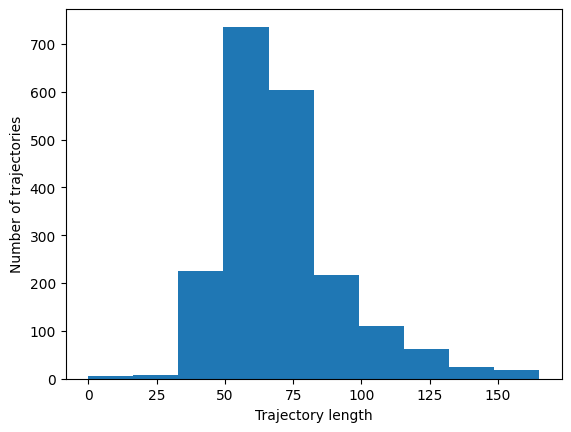

In [12]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories")

In [13]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [14]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [31]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2)

## Data Augmentation

In [18]:
x_train_aug = []
for idx,i in enumerate(x_train):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

        trim = len(i)//2

        if trim >= 5: # Trim if the lengths are greater than 5

            aug = i.head(trim)

        else: # If lengths are not greater than 1, don't trim

            aug = i
    else:
        aug = i


    x_train_aug.append(aug)


In [19]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train)

(1605, 1605)

## Data Formatting

In [32]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [33]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [34]:
# One hot encoding the data for training
y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Model loading and testing

In [4]:
# Testing the saved model
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
model_load = load_model('./models/sep_1/lstm_rnn.h5')
# model_load = load_model('./models/rnn.h5')
# model_load.evaluate(x_test,y_test)

In [5]:
model_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 15)           465       
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 9)            144       
                                                                 
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________


## Interfacing with unity

In [6]:
# Creating a signal interrupt
def signal_handler(signal, frame):
    global interrupted
    interrupted = True
signal.signal(signal.SIGINT, signal_handler)

<function _signal.default_int_handler(signalnum, frame, /)>

In [7]:
data_ = []

In [8]:
def thread_1():
    old = [0.,0.,0.]
    while True:
        time.sleep(0.01)
        if len(data_) > 1:
            if old == data_[-1]:
                continue
            else:
                old = data_[-1]
                ip_data = tf.expand_dims(tf.transpose(tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(np.array(data_).T, padding='post', dtype='float', maxlen=200))),axis =0)
                prediction = model_load.predict(ip_data,verbose = 0)
                conf = prediction[0][len(data_)-1][np.argmax(prediction,axis=2)[0][-1]]
                if conf >= 0.85:
                    pred = np.argmax(prediction,axis=2)[0][-1]
                    print(pred)
                    sock.SendData('Predicted Class: ' + str(pred))
                    reset = True

        if interrupted:
            break

        


In [9]:
def thread_2():

    while True:

        data = sock.ReadReceivedData() # read data

        if data != None: # if NEW data has been received since last ReadReceivedData function call
            data.split(",")
            dt = [float(i) for i in data.split(",") if len(i)]
            cent = [np.mean(dt[0::3]),np.mean(dt[1::3]),np.mean(dt[2::3])]
            if len(data_) == 150:
                data_.pop(0)
            data_.append(cent)
        if reset:
            data_ = []
            reset = False
        if interrupted:
            break
        
        time.sleep(0.01)


In [10]:
interrupted = False
reset = False
sock = U.UdpComms(udpIP="127.0.0.1", portTX=8000, portRX=8001, enableRX=True, suppressWarnings=True)
x_1 = threading.Thread(target=thread_1, args=())
x_2 = threading.Thread(target=thread_2, args=())
x_1.start()
x_2.start()

x_1.join()
x_2.join()

0.99979967
4
0.99886525
4
0.99933404
4
0.9989761
4
0.99862707
4
0.99794775
4
0.998137
4
0.99658173
4
0.92348826
4
0.71195185
4
0.34813434
4
0.5882653
3
0.69626147
4
0.66312474
3
0.6773307
4
0.52098095
3
0.813376
4
0.6415851
4
0.9667572
4
0.9638395
4
0.12320499
4
0.19949456
4
0.109665796
4
0.13932608
4
0.26177478
4
0.13015683
4
0.093424864
4
0.53976643
7
0.9069813
7
0.99395436
7
0.99163085
7
0.9861952
7
0.99945635
7
0.99894756
7
0.9848498
7
0.99176484
7
0.99855536
7
0.9968004
7
0.9338175
7
0.95601606
7
0.5503291
7
0.96518123
7
0.9458666
7
0.014608137
7
0.2273358
4
0.031257186
7
0.18342908
4
0.27842128
7
0.0475834
7
0.09745315
5
0.99407154
8
0.016512437
7
0.06400465
5
0.075011
4
0.50737095
4
0.3613936
4
0.13362387
4
0.95459735
1
0.9685796
1
0.970708
1
0.9704897
1
0.96993726
1
0.96923214
1
0.9679078
1
0.9696507
1
0.9703039
1
0.97152746
1
0.9723936
1
0.97323734
1
0.97362864
1
0.9730645
1
0.97148556
1
0.96240336
1
0.9039501
1
0.031660356
4
0.10668233
4
0.11423851
4
0.135442
4
0.114354454
4


In [ ]:
# !rm -rf ./temp_data/sep_1/data

In [ ]:

# Create UDP socket to use for sending (and receiving)


i = 0
prevdata = 0
while True:
    #sock.SendData('Sent from Python: ' + str(i)) # Send this string to other application
    i += 1

    data = sock.ReadReceivedData() # read data

    if data != None: # if NEW data has been received since last ReadReceivedData function call
        print(data) # print new received data
        # data1=int(data[186:])
        # if((data1-prevdata)>1):
        #     print("missed packet : ",data1)
        # prevdata = data1
    time.sleep(0.01)